In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tensorflow.keras.utils import to_categorical

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
def load_and_preprocess_mnist():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    # Convert grayscale to RGB
    x_train_rgb = np.repeat(x_train[..., np.newaxis], 3, axis=-1)
    x_test_rgb = np.repeat(x_test[..., np.newaxis], 3, axis=-1)

    x_train_resized = tf.image.resize(x_train_rgb, [32, 32]).numpy()
    x_test_resized = tf.image.resize(x_test_rgb, [32, 32]).numpy()

    x_train_resized = x_train_resized.astype('float32') / 255.0
    x_test_resized = x_test_resized.astype('float32') / 255.0

    y_train_cat = to_categorical(y_train, 10)
    y_test_cat = to_categorical(y_test, 10)

    print(f"Training data shape: {x_train_resized.shape}")
    print(f"Test data shape: {x_test_resized.shape}")

    return (x_train_resized, y_train_cat), (x_test_resized, y_test_cat), (y_train, y_test)

In [3]:
def create_vgg16_models():
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(32, 32, 3)
    )

    base_model.trainable = False

    feature_extractor_pre = Model(
        inputs=base_model.input,
        outputs=base_model.get_layer('block5_pool').output,
        name='feature_extractor_pre'
    )

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(10, activation='softmax')(x)

    pre_trained_model = Model(
        inputs=base_model.input,
        outputs=predictions,
        name='vgg16_transfer_learning'
    )

    return base_model, feature_extractor_pre, pre_trained_model

In [4]:
def extract_features_pre_training(feature_extractor_pre, x_data, batch_size=32):
    features = []
    num_batches = len(x_data) // batch_size + (1 if len(x_data) % batch_size != 0 else 0)

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(x_data))
        batch = x_data[start_idx:end_idx]

        batch_features = feature_extractor_pre.predict(batch, verbose=0)
        # Flatten the features
        batch_features_flat = batch_features.reshape(batch_features.shape[0], -1)
        features.append(batch_features_flat)

    return np.vstack(features)

In [5]:
def perform_transfer_learning(model, train_data, val_data, epochs=10):
    x_train, y_train = train_data
    x_val, y_val = val_data

    for layer in model.layers[:-6]:
      layer.trainable = True

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=32,
        verbose=1
    )

    intermediate_layer = model.get_layer('global_average_pooling2d')
    feature_extractor_post = Model(
        inputs=model.input,
        outputs=intermediate_layer.output,
        name='feature_extractor_post'
    )

    return history, feature_extractor_post

In [6]:
def extract_features_post_training(feature_extractor_post, x_data, batch_size=32):

    features = []
    num_batches = len(x_data) // batch_size + (1 if len(x_data) % batch_size != 0 else 0)

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(x_data))
        batch = x_data[start_idx:end_idx]

        batch_features = feature_extractor_post.predict(batch, verbose=1)
        features.append(batch_features)

        if i % 10 == 0:
            print(f"Processed batch {i+1}/{num_batches}")

    return np.vstack(features)

In [7]:
def apply_dimensionality_reduction(features, labels, method='PCA', n_components=2):
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    if method == 'PCA':
        reducer = PCA(n_components=n_components, random_state=42)
    elif method == 'TSNE':
        reducer = TSNE(n_components=n_components, random_state=42, perplexity=30, max_iter=1000)
    elif method == 'LDA':
        reducer = LDA(n_components=min(n_components, len(np.unique(labels))-1))
    else:
        raise ValueError("Method must be 'PCA', 'TSNE', or 'LDA'")

    reduced_features = reducer.fit_transform(features_scaled, labels if method == 'LDA' else None)

    return reduced_features, reducer

In [8]:
def plot_features_2d(features_pre, features_post, labels, methods=['PCA', 'TSNE', 'LDA']):
    n_samples = min(2000, len(features_pre))
    idx = np.random.choice(len(features_pre), n_samples, replace=False)

    features_pre_sample = features_pre[idx]
    features_post_sample = features_post[idx]
    labels_sample = labels[idx]

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    colors = plt.cm.tab10(np.linspace(0, 1, 10))

    for i, method in enumerate(methods):
        # Before transfer learning
        reduced_pre, _ = apply_dimensionality_reduction(
            features_pre_sample, labels_sample, method=method
        )

        ax = axes[0, i]
        scatter = ax.scatter(reduced_pre[:, 0], reduced_pre[:, 1],
                           c=[colors[label] for label in labels_sample],
                           alpha=0.6, s=20)
        ax.set_title(f'Before Transfer Learning - {method}', fontsize=12, fontweight='bold')
        ax.set_xlabel(f'{method} Component 1')
        ax.set_ylabel(f'{method} Component 2')
        ax.grid(True, alpha=0.3)

        # After transfer learning
        reduced_post, _ = apply_dimensionality_reduction(
            features_post_sample, labels_sample, method=method
        )

        ax = axes[1, i]
        scatter = ax.scatter(reduced_post[:, 0], reduced_post[:, 1],
                           c=[colors[label] for label in labels_sample],
                           alpha=0.6, s=20)
        ax.set_title(f'After Transfer Learning - {method}', fontsize=12, fontweight='bold')
        ax.set_xlabel(f'{method} Component 1')
        ax.set_ylabel(f'{method} Component 2')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle('VGG16 Feature Visualization: Before vs After Transfer Learning',
                 fontsize=16, fontweight='bold', y=1.02)
    plt.show()

    return fig

In [9]:
def analyze_feature_separability(features_pre, features_post, labels):
    methods = ['PCA', 'LDA']
    results = {}

    for method in methods:
        # Before transfer learning
        reduced_pre, reducer_pre = apply_dimensionality_reduction(
            features_pre, labels, method=method
        )

        # After transfer learning
        reduced_post, reducer_post = apply_dimensionality_reduction(
            features_post, labels, method=method
        )

        if method == 'PCA':
            explained_var_pre = reducer_pre.explained_variance_ratio_
            explained_var_post = reducer_post.explained_variance_ratio_

            results[method] = {
                'explained_variance_pre': explained_var_pre,
                'explained_variance_post': explained_var_post,
                'total_variance_pre': np.sum(explained_var_pre),
                'total_variance_post': np.sum(explained_var_post)
            }

    return results

In [10]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy During Transfer Learning')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss During Transfer Learning')
    ax2.set_xlabel('Loss')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return fig

In [11]:
def main():

    # Load and preprocess data
    (x_train, y_train_cat), (x_test, y_test_cat), (y_train_orig, y_test_orig) = load_and_preprocess_mnist()

    base_model, feature_extractor_pre, pre_trained_model = create_vgg16_models()

    n_samples = 2000
    x_subset = x_test[:n_samples]
    y_subset_cat = y_test_cat[:n_samples]
    y_subset_orig = y_test_orig[:n_samples]

    features_pre = extract_features_pre_training(feature_extractor_pre, x_subset)

    # Perform transfer learning
    history, feature_extractor_post = perform_transfer_learning(
        pre_trained_model,
        (x_train, y_train_cat),
        (x_test, y_test_cat),
        epochs = 2
    )

    plot_training_history(history)

    features_post = extract_features_post_training(feature_extractor_post, x_subset)

    fig = plot_features_2d(features_pre, features_post, y_subset_orig)

    separability_results = analyze_feature_separability(
        features_pre, features_post, y_subset_orig
    )

    test_loss, test_accuracy = pre_trained_model.evaluate(x_test, y_test_cat, verbose=1)
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Test loss: {test_loss:.4f}")

Training data shape: (60000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
Epoch 1/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 97s 45ms/step - accuracy: 0.5226 - loss: 1.2432 - val_accuracy: 0.9634 - val_loss: 0.1603
Epoch 2/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 131s 43ms/step - accuracy: 0.9320 - loss: 0.2557 - val_accuracy: 0.9805 - val_loss: 0.0739


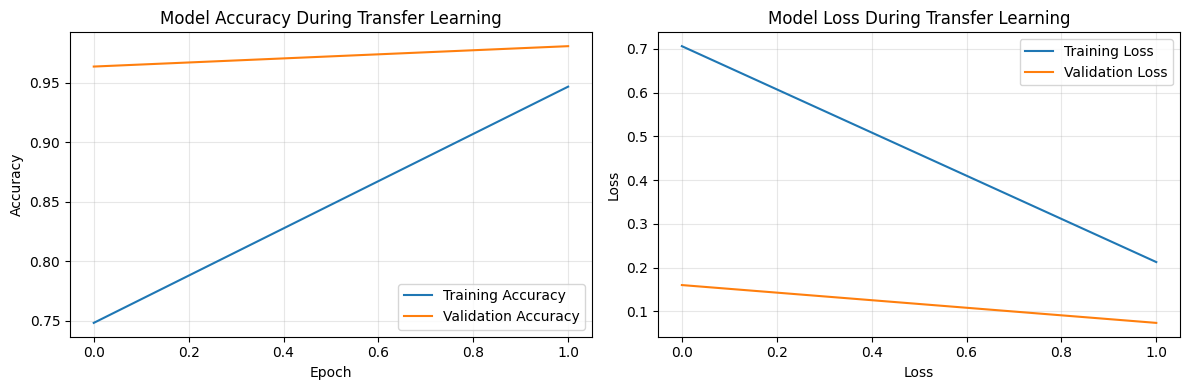

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
Processed batch 1/63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Processed batch 11/63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Processed batch 21/63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━

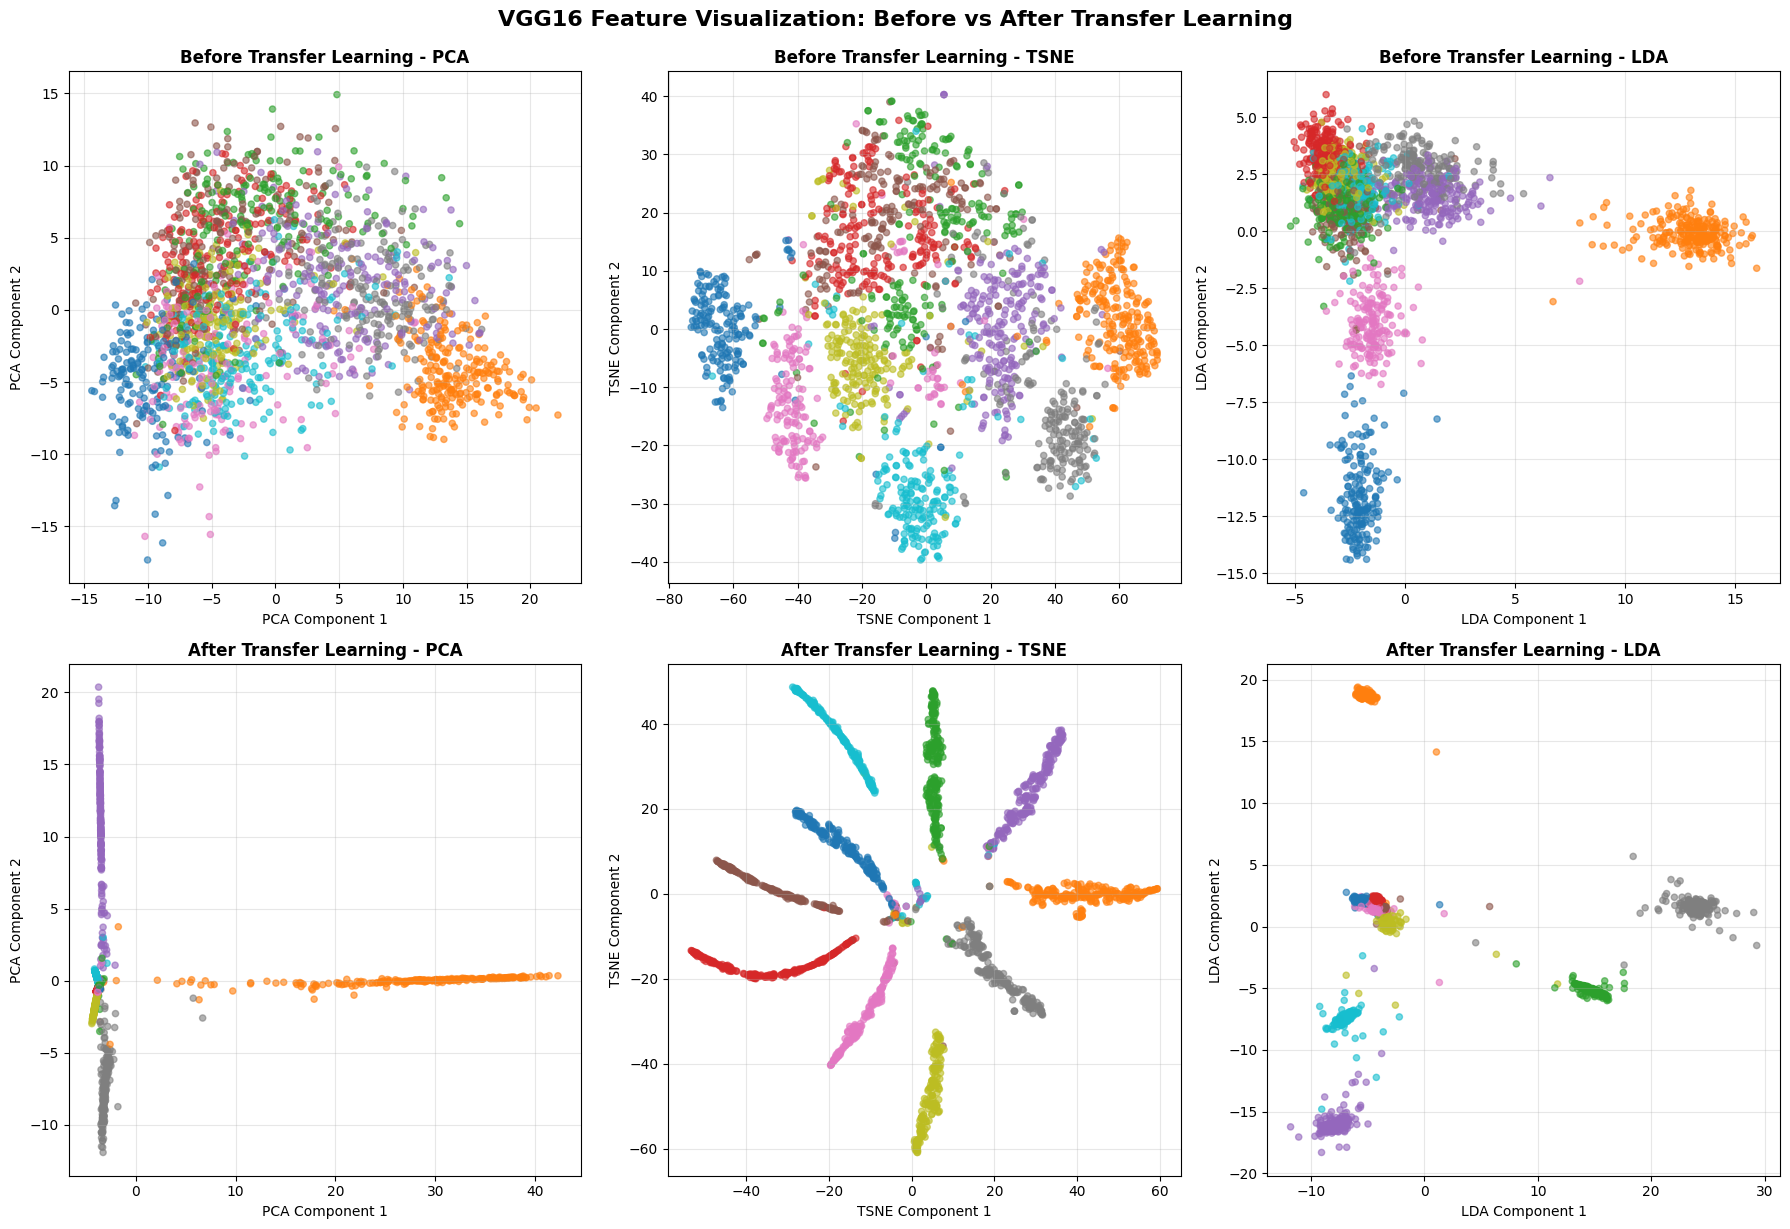

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9741 - loss: 0.0979
Test accuracy: 0.9805
Test loss: 0.0739


In [12]:
if __name__ == "__main__":
    main()